# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import random

# seed our random generator when we want our testing to be consistent between runs
# random.seed(123)

# Load datasets
training_file = '../data/traffic-signs-train.p'
testing_file = '../data/traffic-signs-test.p'
sign_names_file = './signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

sign_names = np.array([])
data_row = False # to help skip over header
import csv
with open(sign_names_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if data_row:
                sign_names = np.append(sign_names, row[1])
            else:
                data_row = True


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Lable data shape = ", y_train[0:])
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Lable data shape =  [ 0  0  0 ..., 42 42 42]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

def select_samples(count, images, labels):
    # select count random images and labels
    # count: number of samples to select
    # images: large image set to sub sample from
    # labels: large label set for the images
    #
    # returns (sample_images, sample_labels)
    indices = np.array(random.sample(range(images.shape[0]), count))
    return (images[indices], labels[indices])

def plot_samples(images, label_names, title, label_indices=None, ncols=2, cmap='jet'):
    # plot the sample images with associated labels
    # images: the images to plotj
    # label_names: label strings for each item in images
    # title: title for the entire plot of images group
    # label_indices: label index for each image plot,  
    #                if None then label_names are assumed to correlate with images input
    # ncols: desired number of columns per row of images in figure
    # cmap: color map
    
    if label_indices is None:
        label_indices = [i for i in range(len(label_names))]
    
    ncount = images.shape[0]
    nrows = ncount / ncols + 1
    
    fig = plt.figure()
    fig.suptitle(title, fontsize=14, y=1.1)
    fig.subplots_adjust(hspace=.5)
    
    for i in range(ncount):
        subplot = plt.subplot(nrows, ncols, i+1)
        subplot.axis('off')
        # we alternate y position to reduce label overlap
        subplot.set_title(label_names[label_indices[i]], y=(1 + 0.25 *(i % 2)))
        image = images[i]
        if image.shape[2] == 1:
            image = image[:,:,0] * 3
        plt.imshow(image, cmap=cmap)


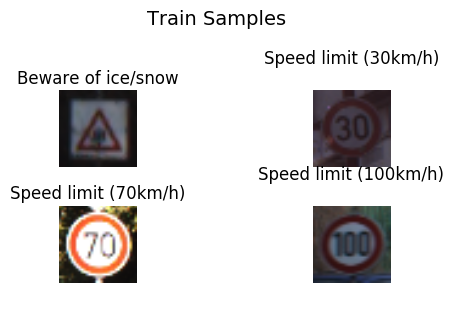

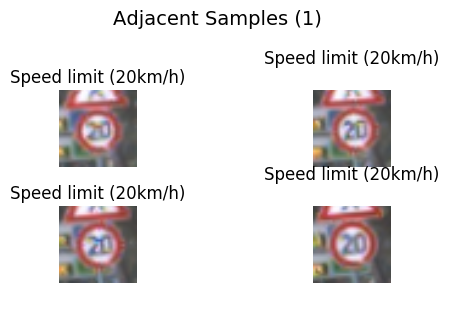

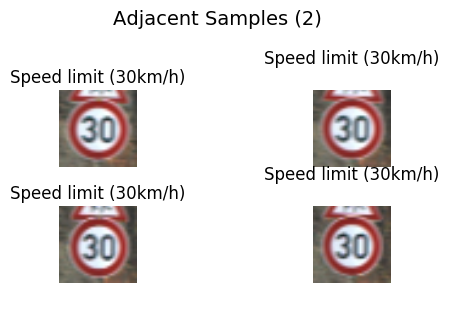

In [4]:
# number of sample images to display for each dataset
n_samples = 4

# select an plot samples from training set
train_sample_images, train_sample_labels = select_samples(n_samples, X_train, y_train)
plot_samples(train_sample_images, sign_names, 'Train Samples', label_indices=train_sample_labels)
plt.show()

# show adjacent images are for the same sign stream
train_sample_images, train_sample_labels = (X_train[0:n_samples], y_train[0:n_samples])
plot_samples(train_sample_images, sign_names, 'Adjacent Samples (1)', label_indices=train_sample_labels)
plt.show()
train_sample_images, train_sample_labels = (X_train[1000:1000 + n_samples], y_train[1000:1000 + n_samples])
plot_samples(train_sample_images, sign_names, 'Adjacent Samples (2)', label_indices=train_sample_labels)
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

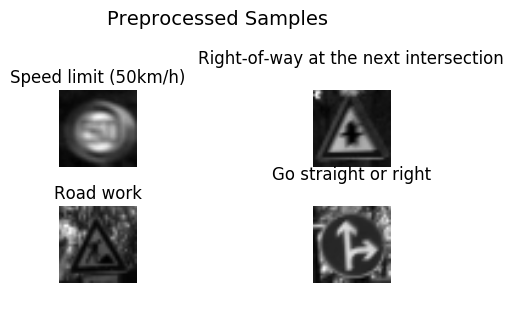

In [5]:
### Preprocess the data here.

import cv2

# resize image to (h, w)
# w: new width
# h: new height
def resize(image, w=32, h=32):
    image = cv2.resize(image, (w, h))
     #print('resize: {}'.format(image.shape))
    return image

# convert image to grayscale (w, h, 3) -> (w, h, 1)
def grayscale(image):
    if len(image.shape) == 3 and image.shape[2] > 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.reshape(image, (image.shape[0], image.shape[1], 1))
    #print('grayscale: {}'.format(image.shape)) 
    return image
    
# normalize values between new_min and new_max
# values: nd array to normalize
# new_min: new minimum value
# new_max: new maximum value
def normalize(values, new_min=-128, new_max=128):
    old_max = np.max(values)
    old_min = np.min(values)
    values = ((new_max - new_min) * (values - old_min)) / (old_max - old_min) + new_min
    #print('normalize: {}'.format(values.shape))
    return values

# preprocessing pipeline to be performed on all images
# resize to standardized dimensions
# convert color images to grayscale
# normalize the image colors centered around zero
def apply_preprocess(image):
    return normalize(grayscale(resize(image)))

# apply the preprocessing routine to each image
X_gray = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2], 1], dtype=int)
for i in range(X_train.shape[0]):
    X_gray[i][:,:] = apply_preprocess(X_train[i])

X_train = X_gray

# redisplay a few images after preprocessing as a sanity check
norm_images, norm_labels = select_samples(n_samples, X_train, y_train)
plot_samples(norm_images, sign_names, 'Preprocessed Samples', label_indices=norm_labels, cmap='gray')
plt.show()


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
We applied the following preprocess pipeline:

1. Convert images of arbitrary dimensions to 32x32

2. Convert multi-channel RGB images to single-channel gray scale images.

3. Normalize the color variation centered around zero, between -128 and 128.

We found most of these ideas in the linked [research paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). Although the provided input images are already 32x32, newly downloaded may not be so this step is performed on any input to the system as 32x32 sized images are assumed by the network. Color is less important than shape according to multiple sources, including the suggested research paper. We did not do enough of our own experimentation to prove this, but intuitively this seemed reasonable to trust. We normalize the variation in the color, also suggested by the research paper.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from random import randint

print("Original training set size: {}".format(X_train.shape[0]))


Original training set size: 39209


In [7]:

# separate out validation_size images from each image class to use as validation set
# in addition to separated sets, returns array sample images, one image from each class
# X_train: images
# y_train: labels
# validation_size: number of images to separate from each image class
def per_feature_split(X_train, y_train, validation_size=30):
    valid_indices = np.array([], dtype='int64')
    count = 0
    samples = np.empty([n_classes, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype=int)
    for sign_id in range(n_classes):
        init_count = valid_indices.shape[0]
        # select all indices for a specific sign_id
        all_indices_for_sign = np.where(y_train == sign_id)[0]
        # we originally tried to extract the first 15% of the indices like the following line
        # int(test_size * all_indices_for_sign.shape[0])
        # but then some items were over represented in the validation set
        # and were giving us suspiciously high or low accuracy estimates
        # we extract a continuous block, rather than randomly because similar images are adjacent
        valid_indices = np.append(valid_indices, all_indices_for_sign[0:validation_size])                            
        end_count = valid_indices.shape[0]
        # we pick index 30 from the class category, this choice is somewhat arbitrary,
        # but index 0 tends to be the first/furthest away in a video series and is more blurry
        samples[sign_id][:,:] = X_train[all_indices_for_sign[validation_size]]

    X_valid = X_train[valid_indices]                              
    y_valid = y_train[valid_indices]
    X_train = np.delete(X_train, valid_indices, axis=0)
    y_train = np.delete(y_train, valid_indices, axis=0)
    
    return (X_train, X_valid, y_train, y_valid, samples)


In [8]:
import scipy.ndimage as ndimage

# apply random changes to the input image
# rotates the image, adds noise to the image
def jitter(image):
    input_shape = image.shape
    # ROTATE
    image = ndimage.rotate(image, random.uniform(-15., 15.), reshape=False)
     
    # NOISE:
    noise = np.random.normal(scale=random.uniform(5., 20.), size=np.shape(image))
    image = image + noise
    
    #print('jitter: {}'.format(image.shape))
    return image


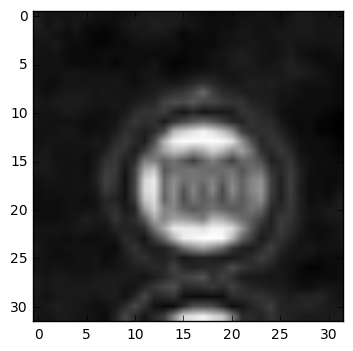

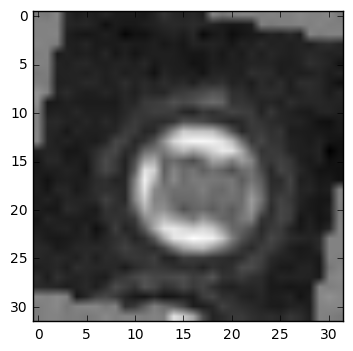

In [9]:
# in this section we just print out an example of a randomly "jittered" image

# simple image plot helper
def test_plot(image):
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image[:,:,0] * 3
    plt.figure()
    plt.imshow(image, cmap='gray')

image = X_train[randint(0, X_train.shape[0])]

test_plot(image)

test = jitter(image)

test_plot(test)



In [10]:
# ensure we have a uniform number of samples from each class
# if a class has fewer examples than the maximum class size,
# we generate jittered variations based on a random selection
# of other images in the same class
# images: total image data set
# labels: labels for data set
# classes: possible classes
# returns the augmented/balanced data set with labels
def balance_data(images, labels, classes):
    # certain classes are overrepresented in the training set
    # we'll augment all the classes so they all have the same number of samples
    from collections import Counter
    counter = Counter(labels)

    largest_class_id, largest_class_size = counter.most_common(2)[0]
    print("largest class size {} for id {} [{}]".format(largest_class_size, largest_class_id, classes[largest_class_id]))

    # create a new placeholder large enough to hold the increased number of dat samples
    augmented_size = largest_class_size * len(classes)
    X_augment = np.empty([augmented_size, images.shape[1], images.shape[2], images.shape[3]], dtype=int)
    y_augment = np.empty([augmented_size], dtype=int)

    # copy the existing images into the augmented set unchanged
    for i in range(images.shape[0]):
        X_augment[i][:,:] = images[i]
        y_augment[i] = labels[i]

    # ensure each class has a number of samples equal to the largest image class
    # add jittered images to increase the number samples for classes with fewer images
    idx = images.shape[0]
    for [class_id, class_size] in counter.most_common():
        diff_size = largest_class_size - class_size
        all_indices_for_sign = np.where(labels == class_id)[0]
        for _ in range(diff_size):
            random_copy_idx = all_indices_for_sign[randint(0, class_size-1)]
            X_augment[idx] = apply_preprocess(jitter(images[random_copy_idx]))
            y_augment[idx] = labels[random_copy_idx]
            idx += 1
    
    return (X_augment, y_augment)


In [ ]:

# separate a validation set out of the training set
X_train, X_valid, y_train, y_valid, sign_samples = per_feature_split(X_train, y_train)

# make sure we have the same number of samples for every class so none are over-represented
X_train, y_train = balance_data(X_train, y_train, sign_names)

# display a few sample images after balancing the data set
check_images, check_labels = select_samples(n_samples, X_train, y_train)
plot_samples(check_images, sign_names, 'Balanced Samples', label_indices=check_labels, cmap='gray')
plt.show()

print("Using {} percent of training as validation".format(
    X_valid.shape[0] / (X_train.shape[0] + X_valid.shape[0]) * 100.))
print("New training set size: {}".format(X_train.shape[0]))
print("Validation size {}".format(X_valid.shape[0]))
print("Sampes of each class: {}".format(sign_samples.shape[0]))



largest class size 2220 for id 2 [Speed limit (50km/h)]


In [12]:
# display a random sample image from every class so we know more about the data

# we leave this commented out, but it can be useful when curious about the data
# plot_samples(sign_samples, sign_names, 'Balanced Samples', label_indices=range(len(sign_samples)), ncols=4, cmap='gray')
# plt.show()


In [13]:
from sklearn.utils import shuffle

# randomize the samples order so we don't gain too much confidence due to similar adjacent images
X_train, y_train = shuffle(X_train, y_train)

# question: does order of the validation set matter?
# it shouldn't, but we shuffle the validation set too, just in case
X_valid, y_valid = shuffle(X_valid, y_valid)

# there's no reason to shuffle the test data, it's already randomized and order should not matter anyway
# X_test, y_test = select_samples(X_test.shape[0], X_test, y_test)

print("Training size: {}".format(X_train.shape[0]))
print("Validation size: {}".format(X_valid.shape[0]))
print("Single sample shape: {}".format(X_train[0].shape))

Training size: 95460
Validation size: 1290
Single sample shape: (32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
We applied the following test/validation split process, inspired by the suggested research paper:

1. Select and 30 images from each sign class to create a new validation set of size 43*30 = 1290. 
    * We selected the first 30 consecutive images from each class because we found that adjacent images were very similar. This reduces diversity in our validation set, but helps reduce the likelyhood of many identical images being present in our training set.
2. Identify the largest class size and create new data to increase the size of smaller classes so that all classes will have the same number of samples, thus balancing the dataset.
    * The largest class contained 2220 images, and with 43 classes our augmented dataset is 95460 samples.
3. Jittered all augmented images.
    * Random images were selected from given samples to augment the dataset. We rotated these images randomly, up to 15 deg in either direction, and then added gaussian noise to the image.
    
        

In [14]:
import tensorflow as tf

# we create the tensorflow variables that define our model (ie. the stuff we save/restore)
# this includes the weights and biases for each layer
def create_model(mu=0, sigma=0.01):
    def new_model():
        return {
            'layer1_W': tf.Variable(tf.truncated_normal((5, 5, 1, 6), mean = mu, stddev = sigma), name='layer1_W'),
            'layer1_b': tf.Variable(tf.zeros(6), name='layer1_b'),
            'layer2_W': tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma), name='layer2_W'),
            'layer2_b': tf.Variable(tf.zeros(16), name='layer2_b'),
            'layer3_W': tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma), name='layer3_W'),
            'layer3_b': tf.Variable(tf.zeros(120), name='layer3_b'),
            'layer4_W': tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma), name='layer4_W'),
            'layer4_b': tf.Variable(tf.zeros(84), name='layer4_b'),
            'layer5_W': tf.Variable(tf.truncated_normal([84, 43], mean = mu, stddev = sigma), name='layer5_W'),
            'layer5_b': tf.Variable(tf.zeros(43), name='layer5_b')
        }
    return new_model()

EPOCHS = 200
BATCH_SIZE = 256

from tensorflow.contrib.layers import flatten

# LeNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def LeNet(x, model):
    
    layer1_W = model['layer1_W']
    layer1_b = model['layer1_b']
    layer2_W = model['layer2_W']
    layer2_b = model['layer2_b']
    layer3_W = model['layer3_W']
    layer3_b = model['layer3_b']
    layer4_W = model['layer4_W']
    layer4_b = model['layer4_b']
    layer5_W = model['layer5_W']
    layer5_b = model['layer5_b']
    
    # we'll use these common pooling parameters for all our pooling
    pool_filter_size = [1, 2, 2, 1]
    pool_stride_size = [1, 2, 2, 1]
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1_strides = [1, 1, 1, 1]
    layer1 = tf.nn.conv2d(x, layer1_W, layer1_strides, 'VALID') + layer1_b

    # Activation.
    act1 = tf.nn.relu(layer1)
    act1 = tf.nn.dropout(act1, act1_keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(act1, pool_filter_size, pool_stride_size, 'SAME')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    layer2_strides = [1, 1, 1, 1]
    layer2 = tf.nn.conv2d(pool1, layer2_W, layer2_strides, 'VALID') + layer2_b

    # Activation.
    act2 = tf.nn.relu(layer2)
    act2 = tf.nn.dropout(act2, act2_keep_prob)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(act2, pool_filter_size, pool_stride_size, 'SAME')

    # Flatten. Input = 5x5x16. Output = 400.
    flat2 = tf.contrib.layers.flatten(pool2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3_fc = tf.reshape(flat2, [-1, layer3_W.get_shape().as_list()[0]])
    layer3_fc = tf.add(tf.matmul(layer3_fc, layer3_W), layer3_b)

    # Activation.
    act3 = tf.nn.relu(layer3_fc)
    act3 = tf.nn.dropout(act3, act3_keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4_fc = tf.reshape(act3, [-1, layer4_W.get_shape().as_list()[0]])
    layer4_fc = tf.add(tf.matmul(layer4_fc, layer4_W), layer4_b)
    
    # Activation.
    act4 = tf.nn.relu(layer4_fc)
    act4 = tf.nn.dropout(act4, act4_keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    layer5_fc = tf.reshape(act4, [-1, layer5_W.get_shape().as_list()[0]])
    layer5_fc = tf.add(tf.matmul(layer5_fc, layer5_W), layer5_b)
    
    logits = layer5_fc
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
We used the LeNet architecure from a previous lesson. We modified the Activation layers slightly to use DropOut at each layer, and we increased the number of EPOCHS so that the network would have enough tries to still learn after dropping neurons. The liklihood of dropping neurons increases in deeper layers.

Our LeNet network is:
        
    conv -> act -> drop(0.9) -> pool -> 
    conv -> act -> drop(0.7) -> pool -> 
    flat -> fc -> act -> drop(0.6) -> 
    fc -> act -> drop(0.5) -> 
    fc -> complete
        
We use the ReLU method of activation at each activation layer.
        

In [15]:
### Train your model here.

# our model
model = create_model()

# placeholder vars
x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43)

# activations for each layer
act1_keep_prob = tf.placeholder(tf.float32, name='act1_keep_prob')
act2_keep_prob = tf.placeholder(tf.float32, name='act2_keep_prob')
act3_keep_prob = tf.placeholder(tf.float32, name='act3_keep_prob')
act4_keep_prob = tf.placeholder(tf.float32, name='act4_keep_prob')

# learning rate
rate = 0.001

# the learning process
logits = LeNet(x, model)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# how the cnn performed after each epoch
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,
                                                               act1_keep_prob: 1.0,
                                                               act2_keep_prob: 1.0,
                                                               act3_keep_prob: 1.0,
                                                               act4_keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
from time import time

save_prefix = 'lenet-traffic-signs'
last_saved_file = None
saver = tf.train.Saver(model)
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    all_epoch_start_time = time()
    for i in range(EPOCHS):
        t0 = time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                        act1_keep_prob: 0.9,
                                                        act2_keep_prob: 0.7,
                                                        act3_keep_prob: 0.6,
                                                        act4_keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Duration: {}s".format(round(time() - t0, 3)))
        print()
        
    total_time = round(time() - all_epoch_start_time, 3) 
    print("Average Epoch Duration: {}s".format(total_time / EPOCHS))
    print("Time for {} Epochs: {}s".format(EPOCHS, total_time))
    
    last_saved_file = '{}-{}.ckpt'.format(save_prefix, validation_accuracy)
    saver.save(sess, last_saved_file)
    print("Model saved as: {}".format(last_saved_file))

Training...

EPOCH 1 ...
Validation Accuracy = 0.722
Duration: 2.677s

EPOCH 2 ...
Validation Accuracy = 0.764
Duration: 2.238s

EPOCH 3 ...
Validation Accuracy = 0.784
Duration: 2.36s

EPOCH 4 ...
Validation Accuracy = 0.771
Duration: 2.216s

EPOCH 5 ...
Validation Accuracy = 0.801
Duration: 2.364s

EPOCH 6 ...
Validation Accuracy = 0.791
Duration: 2.254s

EPOCH 7 ...
Validation Accuracy = 0.801
Duration: 2.309s

EPOCH 8 ...
Validation Accuracy = 0.808
Duration: 2.129s

EPOCH 9 ...
Validation Accuracy = 0.811
Duration: 2.32s

EPOCH 10 ...
Validation Accuracy = 0.792
Duration: 2.262s

EPOCH 11 ...
Validation Accuracy = 0.854
Duration: 2.397s

EPOCH 12 ...
Validation Accuracy = 0.839
Duration: 2.274s

EPOCH 13 ...
Validation Accuracy = 0.797
Duration: 2.373s

EPOCH 14 ...
Validation Accuracy = 0.835
Duration: 2.287s

EPOCH 15 ...
Validation Accuracy = 0.836
Duration: 2.373s

EPOCH 16 ...
Validation Accuracy = 0.795
Duration: 2.283s

EPOCH 17 ...
Validation Accuracy = 0.820
Duration: 2.3

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Optimizer: AdamOptimizer instead of basic GradientDecent. More about the difference was available on stackoverflow, but we summarize that for ourselves as Adam Optimizer being generally simpler to use, saving the developer time in tuning, with the tradeoff being AdamOptimizer uses more memory and compute time. (http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow).

Batch Size: 256

Epochs: 200

hyperparameters:
* weight initializers, mu=0.0, sigma=0.01
* learning rate: 0.001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._


**Answer:**

The main strategy we used for solving the problem was the LeNet architecture. We assumed it would work well enough for matching Traffic Sign shapes because it did well at matching character shapes in the MNIST data. After that, we read a variety of research papers online to get ideas for data preparation. 

Using LeNET unmodified gave us 95% accuracy on the training set. Our final results, after dropout and data augmentation were not this high on the training set, running closer to 90-93%.

The purpose of dropout and data augmentation was to help avoid overfitting to the training set, even though we anticipated a lower score on the training set.

We performed a significant amount of trial and error with most of the tuning parameters like learning rate, batch size, EPOCHS and various data preparation strategies.

We did not do a rigorous job of note taking on results for each of the experiments. I generally recall Grayscale providing the best improvement. Both DropOut and our modified splitting strategy cause worse performance on the validation set. Our results on unseen images from the web improved significantly (5% or so) after we balanced the training data and augmented it with jittered data.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

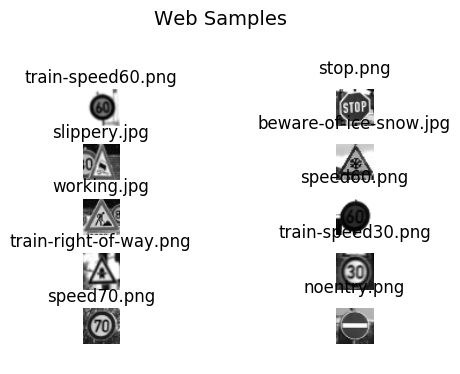

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import numpy as np
import matplotlib.image as mpimg
import cv2

# directory of sample signs downloaded from web
web_signs_path = './web_signs'

web_file_names = os.listdir(web_signs_path)

# preprocess downloaded images
web_images = np.empty([len(web_file_names), 32, 32, 1])
for idx, file_name in enumerate(web_file_names):
    img = cv2.imread('/'.join([web_signs_path, file_name]))
    web_images[idx][:,:] = apply_preprocess(img)

# display downloaded images
plot_samples(web_images, web_file_names, 'Web Samples', cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
We searched the web for a few candidate images of german signs and cropped them to focus on the sign itself rather than the surrounding area, similar to how the training data looked. We also grabbed three arbitrary images directly from the training set to see whether the classifier would recognize them again after training.

The 'beware-of-ice-snow.jpg' image is the toughest for the network to recognize, and is usually identified as 'right of way next intersection' first, with 'ice and snow' as a second choice. The slippery road sign is also difficult to match sometimes because of similarities to 'winding road' and 'steep curve ahead'.

In [20]:
import tensorflow as tf
import os

# clear the tensorflow graph
tf.reset_default_graph()

# placholders for the activation probabilities
act1_keep_prob = tf.placeholder(tf.float32, name='act1_keep_prob')
act2_keep_prob = tf.placeholder(tf.float32, name='act2_keep_prob')
act3_keep_prob = tf.placeholder(tf.float32, name='act3_keep_prob')
act4_keep_prob = tf.placeholder(tf.float32, name='act4_keep_prob')

### Run the predictions here.
def predict(X_data, save_file):  
    x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')
    model = create_model()
    logits = LeNet(x, model)
    softmax = tf.nn.softmax(logits)
    result = None
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, save_file)
        print('X_data shape: {}'.format(X_data.shape))
        result = sess.run(softmax, feed_dict={x: X_data, 
                                              act1_keep_prob: 1.0, 
                                              act2_keep_prob: 1.0, 
                                              act3_keep_prob: 1.0, 
                                              act4_keep_prob: 1.0})
    return result

#uncomment below and change file name to use pre-existing file from previous run 
#last_saved_file = 'lenet-traffic-signs-0.8201550387596899.ckpt'

# predict labels for the signs we downloaded from the web
softmax_probs = predict(web_images, '{}/{}'.format(os.getcwd(), last_saved_file))

# print the sign id and sign name for each prediction on the downloaded images
print('Predictions for Each of Our Downloaded Image Samples')
predicted_label_index = np.argmax(softmax_probs, axis=1)
for idx, name in zip(predicted_label_index, sign_names[predicted_label_index]):
    print('{}: {}'.format(idx, name))


X_data shape: (10, 32, 32, 1)
Predictions for Each of Our Downloaded Image Samples
3: Speed limit (60km/h)
14: Stop
21: Double curve
30: Beware of ice/snow
25: Road work
3: Speed limit (60km/h)
11: Right-of-way at the next intersection
1: Speed limit (30km/h)
4: Speed limit (70km/h)
17: No entry


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


# **Answer:**
The model predicted 9/10 correctly, or 90%. This sounds better than it is. We know from experimentation that 'ice-and-snow' could just as easily have been picked wrong with slightly different weights, even if our training accuracy had been higher. More rigorous testing and documentation of results would need to be done to build confidence in the model as it is, but are still happy with the results for the purpose of the assignment.

The visualization displays the image evaluted on the left, and a probability chart along the right. In the probability chart, the x-axis is labeled 0-42 for each of the sign ids. Black color indicates near zero probability, while white indicates closer to 1.0 probability. 


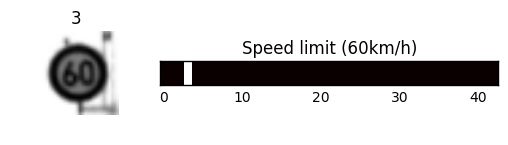

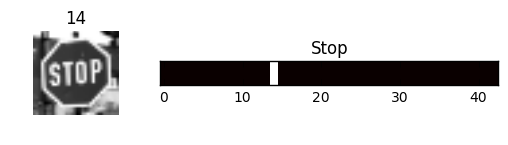

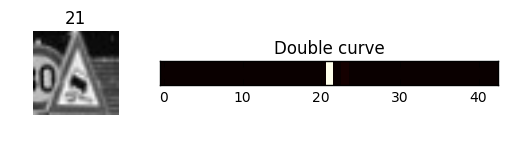

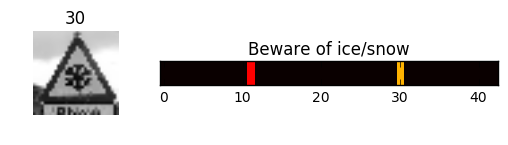

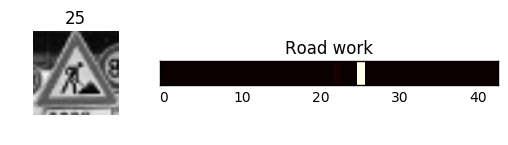

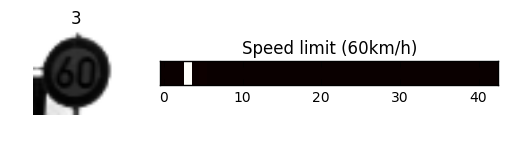

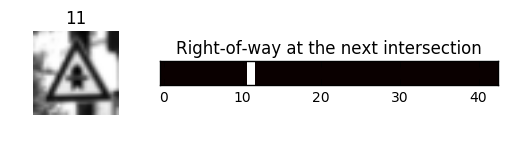

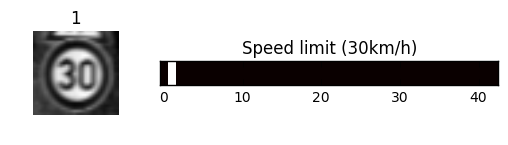

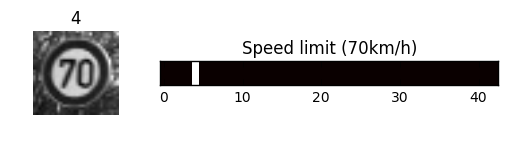

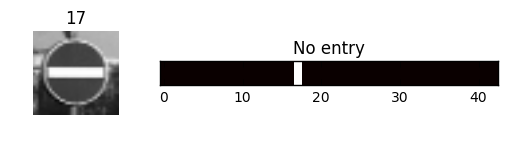

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

from matplotlib import gridspec

# show the images on the left column, and a kind probability indicator on the right.
# in the probability bar ligher colors are more likely predictions and darker are less likely
# white is highly likely, black is very unlikely
def visualize_prediction(pred, image, label_index, label_name, title, cmap='gray'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=.5)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4], height_ratios=[1,1])
    subplot = plt.subplot(gs[0])
    subplot.set_title(label_index)
    subplot.axis('off')
    
    if image.shape[2] == 1:
        image = image[:,:,0] * 3
    plt.imshow(image, cmap=cmap)
   
    subplot = plt.subplot(gs[1])
    subplot.set_title(label_name)
    subplot.axes.get_yaxis().set_visible(False)
    probs = np.array([pred, pred, pred])
    plt.imshow(probs, interpolation='nearest', cmap='hot', vmin=0.0, vmax=1.0)

predicted_label_index = np.argmax(softmax_probs, axis=1)
for pred, image, label_index, lable_name, file_name in zip(softmax_probs, web_images, predicted_label_index, sign_names[predicted_label_index], web_file_names):
    visualize_prediction(pred, image, label_index, lable_name, file_name)
    
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Slippery road was guess wrong as 'double curve', but we see the correct guess is in second place. The previous probability visualization does not reveal this as a very close second, as the colors are too dark to distinguish from just black. 

For the Beware of ice/snow, the prediction is correct but 'right-of-way' is a very close second in terms of the probability numbers.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

TopK: TopKV2(values=array([[  9.99984741e-01,   1.51927061e-05,   6.58071242e-09],
       [  1.00000000e+00,   2.61004126e-37,   0.00000000e+00],
       [  9.79546487e-01,   1.65651254e-02,   1.49390404e-03],
       [  6.32031262e-01,   3.65959138e-01,   1.42090721e-03],
       [  9.77430224e-01,   2.25695260e-02,   1.69886206e-07],
       [  9.93370771e-01,   6.48578396e-03,   5.66487179e-05],
       [  1.00000000e+00,   9.11707043e-10,   2.05953811e-13],
       [  1.00000000e+00,   4.06650720e-11,   1.89458171e-11],
       [  1.00000000e+00,   5.82338136e-11,   8.06255246e-16],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[ 3,  5,  2],
       [14, 33,  0],
       [21, 23, 11],
       [30, 11, 38],
       [25, 22, 20],
       [ 3,  5,  2],
       [11, 30, 28],
       [ 1,  2,  4],
       [ 4,  1,  0],
       [17,  0,  1]], dtype=int32))


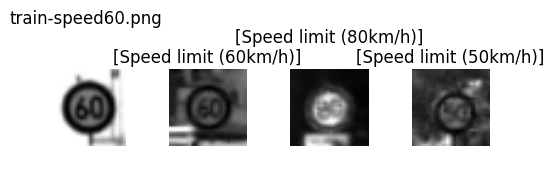

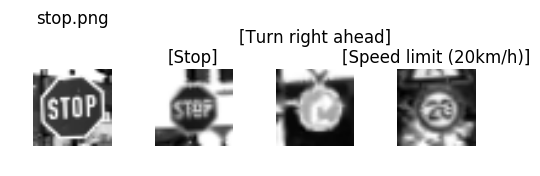

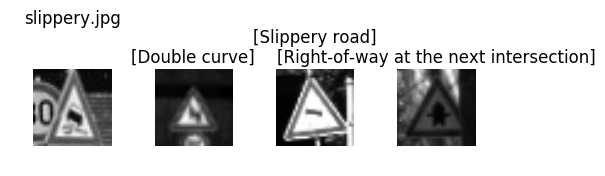

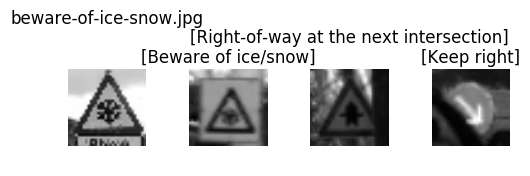

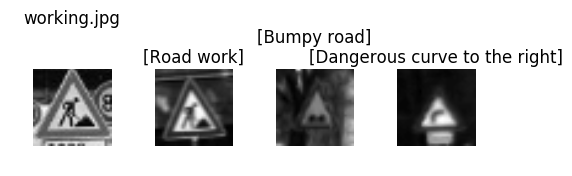

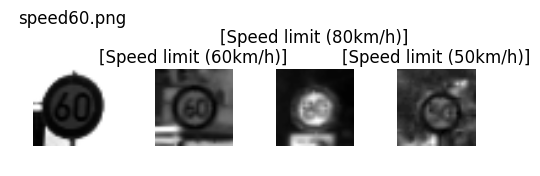

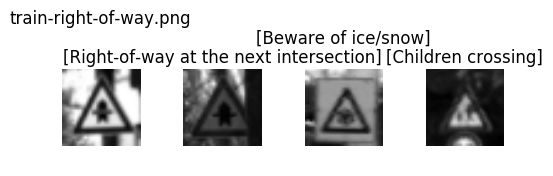

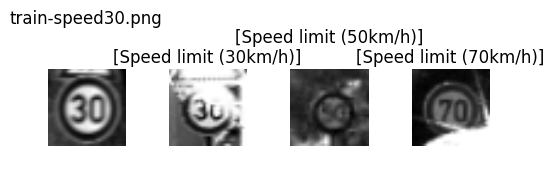

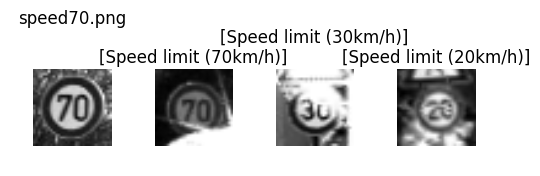

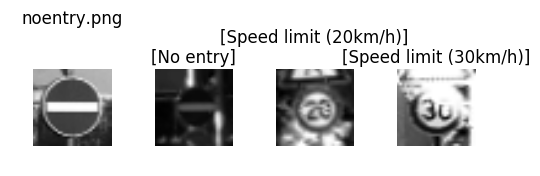

In [22]:
def format_image_for_display(image):
    if image.shape[2] == 1:
        image = image[:,:,0] * 3
    return image

# display topk images
# display the actual sample image on the left column
# display a sample from each of the first k classes
# to visually compare to what the actual images is
def visualize_topk(top_indices, image, file_name, class_images, class_names, cmap='gray'):
    fig = plt.figure()
    
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
    
    #  plot evaluated image
    subplot = plt.subplot(gs[0])
    subplot.set_title(file_name, y=1.5)
    subplot.axis('off')
    image = format_image_for_display(image)
    plt.imshow(image, cmap=cmap)
   
    # plot the topk choices predicted
    for p, i in enumerate(top_indices):
        subplot = plt.subplot(gs[p + 1])
        subplot.set_title('[{}]'.format(class_names[i]), y=(1 + 0.25 *(p % 2)))
        subplot.axis('off')
        image = format_image_for_display(class_images[i])
        plt.imshow(image, cmap=cmap)

with tf.Session() as sess:
    topk = sess.run(tf.nn.top_k(tf.constant(softmax_probs), k=3))
    print("TopK: {}".format(topk))

for top_indices, image, file_name in zip(topk[1], web_images, web_file_names):
    visualize_topk(top_indices, image, file_name, sign_samples, sign_names)

In [27]:
# Finally Let's See How We Do on Test
# clear the tensorflow graph
tf.reset_default_graph()

# preprocess
X_prep = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2], 1], dtype=int)
for i in range(X_test.shape[0]):
    X_prep[i][:,:] = apply_preprocess(X_test[i])

X_test = X_prep


In [30]:
# our model
model = create_model()

# placeholder vars
x = tf.placeholder(tf.float32, (None, X_test.shape[1], X_test.shape[2], X_test.shape[3]), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43)

# activations for each layer
act1_keep_prob = tf.placeholder(tf.float32, name='act1_keep_prob')
act2_keep_prob = tf.placeholder(tf.float32, name='act2_keep_prob')
act3_keep_prob = tf.placeholder(tf.float32, name='act3_keep_prob')
act4_keep_prob = tf.placeholder(tf.float32, name='act4_keep_prob')

logits = LeNet(x, model)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, last_saved_file)
    test_accuracy = sess.run(evaluate(X_test, y_test))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for lenet-traffic-signs-0.8201550387596899.ckpt
	 [[Node: save_1/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_1/tensor_names, save_1/RestoreV2_1/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_8/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_13_save_1/RestoreV2_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_1', defined at:
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-6ba1f2a40b6c>", line 21, in <module>
    saver = tf.train.Saver()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/bmoriarty/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for lenet-traffic-signs-0.8201550387596899.ckpt
	 [[Node: save_1/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_1/tensor_names, save_1/RestoreV2_1/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_8/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_13_save_1/RestoreV2_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
